# EarthMIP Trial

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
# from bayesevt._src.data.ics import LocalDataSource
from bayesevt._src.models.earth2mip import VARIABLES

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

In [23]:
model = "pangu" # "fcnv2_sm" # 
# channel_names = VARIABLES["fcnv2_sm"]
channel_names = VARIABLES[model]

In [24]:
# channel_names_pangu

In [25]:
# model_name = "pangu" #"fcnv2_sm" # "fcn" # 
# model = f"e2mip://{model_name}"
# device = "cpu"

In [26]:
# time_loop  = get_model(
#     model=model,
#     device=device,
# )

# channel_names = time_loop.in_channel_names

In [27]:
# channel_names

## Initial Condition

In [28]:
# starting timestep
t0 = datetime.datetime(2021,8,1)
# number of forecast steps
num_steps = 10 # 6h intervals

In [29]:
from bayesevt._src.dtypes.time import Time

### Download Manually

In [30]:
from bayesevt._src.data.era5.ops import parse_single_levels, parse_pressure_levels, parse_all_variables
from bayesevt._src.data.era5.variables import VARIABLES_SURFACE
from bayesevt._src.dtypes.grid import Grid, RES025
from bayesevt._src.dtypes.region import Region, GLOBE

# save path
raw_data_path = "/pool/proyectos/CLINT/sa4attrs/data/raw"

# create a custom time variable
time = Time(year=2021, month=8, day=1)

# parse single levels
sl_variables = parse_single_levels(channel_names)
assert list(map(lambda x: x.name, sl_variables)) == list(filter(lambda x: x in VARIABLES_SURFACE, channel_names))

# parse pressure levels
pl_variables = parse_pressure_levels(channel_names)
assert list(map(lambda x: x.name, pl_variables)) == list(filter(lambda x: x not in VARIABLES_SURFACE, channel_names))

# parse all levels
all_variables = parse_all_variables(channel_names)
assert list(map(lambda x: x.name, all_variables)) == channel_names

In [31]:
# get unique names 
from toolz.functoolz import compose_left

# get surface variables
vars_surface = set(filter(lambda x: x.name in VARIABLES_SURFACE, all_variables))
vars_surface = set(map(lambda x: x.era5_name, vars_surface))

# get pressure variables
vars_pressure = set(filter(lambda x: x.name not in VARIABLES_SURFACE, all_variables))
unique_levels = set(map(lambda x: x.level, vars_pressure))
vars_pressure = set(map(lambda x: x.era5_name, vars_pressure))

In [32]:
print(f"Single Level Variables: \n{vars_surface}")
print(f"Pressure Level Variables: \n{vars_pressure}")
print(f"Levels: \n{unique_levels}")

Single Level Variables: 
{'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_u_component_of_wind', '2m_temperature'}
Pressure Level Variables: 
{'u_component_of_wind', 'temperature', 'v_component_of_wind', 'geopotential', 'specific_humidity'}
Levels: 
{100, 1000, 200, 300, 400, 850, 50, 500, 150, 600, 250, 700, 925}


In [33]:
vars_all = list(vars_surface) + list(vars_pressure)

In [34]:
vars_all

['mean_sea_level_pressure',
 '10m_v_component_of_wind',
 '10m_u_component_of_wind',
 '2m_temperature',
 'u_component_of_wind',
 'temperature',
 'v_component_of_wind',
 'geopotential',
 'specific_humidity']

### Data

Normally, I would use the CDSAPI but it's being extremely slow these days. 
So I'll use [googles version](https://github.com/google-research/arco-era5?tab=readme-ov-file) they have which is all of ERA5.
They're missing specific humidity...

In [36]:
import xarray as xr

# cloud_dir = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
cloud_dir = "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr"
ds = xr.open_zarr(cloud_dir)
ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

**Preprocessing**

* select variables
* select time period
* select levels

In [ ]:
%%time

# subset variables
ds_subset = ds[vars_all]
# select event
ds_subset = ds_subset.sel(time=slice("2018-07-20", "2018-08-10"))
# select levels
ds_subset = ds_subset.sel(level=list(unique_levels))
# resample to 1D
ds_subset = ds_subset.resample(time="1D").mean()

ds_subset = ds_subset.load()

In [42]:
ds_subset

<xarray.Dataset> Size: 6GB
Dimensions:                  (time: 22, latitude: 721, longitude: 1440,
                              level: 13)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * level                    (level) int64 104B 100 1000 200 300 ... 250 700 925
  * longitude                (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                     (time) datetime64[ns] 176B 2018-07-20 ... 2018-0...
Data variables:
    mean_sea_level_pressure  (time, latitude, longitude) float32 91MB 1.001e+...
    10m_v_component_of_wind  (time, latitude, longitude) float32 91MB -0.0492...
    10m_u_component_of_wind  (time, latitude, longitude) float32 91MB 0.0703 ...
    2m_temperature           (time, latitude, longitude) float32 91MB 273.6 ....
    u_component_of_wind      (time, level, latitude, longitude) float32 1GB -...
    temperature              (time, level, latitude, longitude) float32 1GB 2...
    v_component_of_wind      (time, level, latitude, longitude) float32 1GB 0...
    geopotential             (time, level, latitude, longitude) float32 1GB 1...
    specific_humidity        (time, level, latitude, longitude) float32 1GB 2...

In [43]:
%%time
save_name = "20180715_20180830_pangu_ics"
ds_subset.to_netcdf(f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc")

CPU times: user 125 ms, sys: 4.55 s, total: 4.68 s
Wall time: 11.4 s


In [74]:
from bayesevt._src.data.era5.variables import VariableSingleLevel, VariablePressureLevel
ids_subset = ds_subset.sel(time=t0, method="nearest")
ds_new = []
for ivar in all_variables:
    # select variable
    if isinstance(ivar, VariableSingleLevel):
        ids = ids_subset[ivar.era5_name]
    elif isinstance(ivar, VariablePressureLevel):
        ids = ids_subset[ivar.era5_name].sel(level=ivar.level).drop_vars('level')
        
    ds_new.append(ids.transpose("latitude", "longitude"))

In [76]:
ds_new_ = xr.concat(ds_new, dim="channels")
# ds_new_ = ds_new_.transpose
ds_new_ = ds_new_.assign_coords({"channels": channel_names})
ds_new_ = ds_new_.assign_coords({"time": t0})
ds_new_ = ds_new_.rename("data")
ds_new_

<xarray.DataArray 'data' (channels: 69, latitude: 721, longitude: 1440)> Size: 287MB
array([[[ 8.12756226e+02,  8.12756226e+02,  8.12756226e+02, ...,
          8.12756226e+02,  8.12756226e+02,  8.12756226e+02],
        [ 7.90125610e+02,  7.90188843e+02,  7.90315308e+02, ...,
          7.89841187e+02,  7.89935913e+02,  7.90030762e+02],
        [ 7.68063965e+02,  7.68221985e+02,  7.68411682e+02, ...,
          7.67494995e+02,  7.67684692e+02,  7.67874329e+02],
        ...,
        [ 1.39116418e+03,  1.39069019e+03,  1.39018433e+03, ...,
          1.39268127e+03,  1.39214392e+03,  1.39163818e+03],
        [ 1.37226306e+03,  1.37185229e+03,  1.37144141e+03, ...,
          1.37346411e+03,  1.37305347e+03,  1.37267407e+03],
        [ 1.41161389e+03,  1.41161389e+03,  1.41161389e+03, ...,
          1.41161389e+03,  1.41161389e+03,  1.41161389e+03]],

       [[ 6.99699316e+03,  6.99699316e+03,  6.99699316e+03, ...,
          6.99699316e+03,  6.99699316e+03,  6.99699316e+03],
        [ 6.96813818e+03,  6.96820166e+03,  6.96829639e+03, ...,
          6.96775781e+03,  6.96788477e+03,  6.96797998e+03],
        [ 6.94184863e+03,  6.94203857e+03,  6.94226025e+03, ...,
          6.94127832e+03,  6.94143652e+03,  6.94165820e+03],
...
         -4.48341608e+00, -4.50468731e+00, -4.52314568e+00],
        [-4.70966721e+00, -4.71828127e+00, -4.72689533e+00, ...,
         -4.67767191e+00, -4.68804407e+00, -4.69894361e+00],
        [ 1.11056715e-01,  1.11056715e-01,  1.11056715e-01, ...,
          1.11056715e-01,  1.11056715e-01,  1.11056715e-01]],

       [[ 2.74315674e+02,  2.74315674e+02,  2.74315674e+02, ...,
          2.74315674e+02,  2.74315674e+02,  2.74315674e+02],
        [ 2.74192261e+02,  2.74192261e+02,  2.74192688e+02, ...,
          2.74193146e+02,  2.74192688e+02,  2.74192688e+02],
        [ 2.74105957e+02,  2.74105957e+02,  2.74106384e+02, ...,
          2.74108551e+02,  2.74106384e+02,  2.74106384e+02],
        ...,
        [ 2.26704056e+02,  2.26708801e+02,  2.26716568e+02, ...,
          2.26681625e+02,  2.26691116e+02,  2.26699738e+02],
        [ 2.27107086e+02,  2.27111404e+02,  2.27116150e+02, ...,
          2.27091980e+02,  2.27096283e+02,  2.27101471e+02],
        [ 2.26663925e+02,  2.26663925e+02,  2.26663925e+02, ...,
          2.26663925e+02,  2.26663925e+02,  2.26663925e+02]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    time       datetime64[ns] 8B 2021-08-01
  * channels   (channels) <U5 1kB 'z1000' 'z925' 'z850' ... 'u10m' 'v10m' 't2m'
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [93]:
from bayesevt._src.data.ics import LocalDataSourceNC

In [94]:
file_paths = [f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"]
# initial condition
data_source = LocalDataSourceNC(
    channel_names=channel_names,
    file_paths=file_paths
)
# initial condition
# data_source = cds.DataSource(time_loop.in_channel_names)

In [95]:
data_source[t0]

<xarray.DataArray 'geopotential' (channel: 69, latitude: 721, longitude: 1440)> Size: 287MB
dask.array<concatenate, shape=(69, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    time       datetime64[ns] 8B 2018-08-10
Dimensions without coordinates: channel
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2


<xarray.DataArray 'geopotential' (channel: 69, lat: 721, lon: 1440)> Size: 287MB
dask.array<rechunk-merge, shape=(69, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time     datetime64[ns] 8B 2021-08-01
  * channel  (channel) <U5 1kB 'z1000' 'z925' 'z850' ... 'u10m' 'v10m' 't2m'
  * lon      (lon) float32 6kB 180.0 180.2 180.5 180.8 ... 539.2 539.5 539.8
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [13]:
import xarray as xr
ds_ = xr.open_mfdataset("/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm*", engine="cfgrib")

ds_

<xarray.Dataset>
Dimensions:        (latitude: 721, longitude: 1440, isobaricInhPa: 13)
Coordinates:
    number         int64 0
    time           datetime64[ns] 2021-08-01
    step           timedelta64[ns] 00:00:00
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     datetime64[ns] 2021-08-01
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 925.0 850.0 ... 100.0 50.0
Data variables: (12/13)
    sp             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    tcwv           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    msl            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u10            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    v10            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    t2m            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...             ...
    v100           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    z              (isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    t              (isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    u              (isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    v              (isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    r              (isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-02-21T02:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [14]:
ds_.to_netcdf("/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_20210801.nc")

In [15]:
# local_path = "/pool/proyectos/CLINT/sa4attrs/data/raw/2021_08_01-full_37-1h-0p25deg-chunk-1.zarr"
# local_path = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
# ds = xr.open_zarr(local_path)
# ds

In [16]:
local_path = "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_20210801.nc"

In [61]:
from bayesevt._src.data.era5.variables import SingleLevelCode, PressureLevelCode
from tqdm.auto import tqdm
# empty arrays
arrays = [None] * len(all_variables)
with xr.open_zarr(local_path) as f:

    for i, icode in tqdm(enumerate(all_variables)):

        if isinstance(icode, SingleLevelCode):
            # extract variable from pressure code
            variable = SHORT_NAME_2_LONG_NAME[icode.name]
            arrays[i] = f[variable].sel(time=t0).values
        elif isinstance(icode, PressureLevelCode):
            # extract variable from pressure code
            variable = SHORT_NAME_2_LONG_NAME[icode.name]
            arrays[i] = f[variable].sel(time=t0, level=icode.level).values
        else:
            raise ValueError(f"Unrecognized Code")
        # try:
        #     i = codes.index(code)
            
        #     arrays[i] = values
        # while True:
        # grab first variable
        
        
        # gid = eccodes.codes_grib_new_from_file(f)
        # # logger.debug(f"GID: {gid}")
        
        # if gid is None:
        #     break
        # # extract codes
        # id, level, level_type = extract_grib_params(gid)
        # # logger.debug(f"ID: {id} | LEVEL: {level} | Type: {level_type}")
        
        # # Create Unique Code to Match List of Variables
        # if level_type == "surface":
        #     code = SingleLevelCode.from_id(id=id)
        # elif level_type == "isobaricInhPa":
        #     code = PressureLevelCode.from_id_and_level(id=id, level=level)
        
        # # check if Unique Code Exists
        # try:
        #     i = codes.index(code)
        # except ValueError:
        #     continue
        # # extract coordinates and values
        # lat, lon, values = extract_grib_vals_and_coords(gid)
        # # logger.debug(f"Array SIZE: {values.shape}")
        
        # # release codes
        # eccodes.codes_release(gid)
        
        # # aggregrate arrays
        # 



0it [00:00, ?it/s]

KeyError: "No variable named '100m_u_component_of_wind'. Variables on the dataset include ['10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed', '2m_dewpoint_temperature', '2m_temperature', ..., 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'vorticity', 'wind_speed']"

In [60]:
# check all IDs are the same
msg = f"Number of Variables is not the same as arrays..."
msg += f"\nNumber of Variables: {len(all_variables)}"
msg += f"\nNumber of Arrays: {len(arrays)}"
assert len(arrays) == len(codes), msg


# create xarray dataset
arrays = np.stack(arrays)
coords = {}
coords["lon"] = lon[0, :]
coords["lat"] = lat[:, 0]
ds = xr.DataArray(arrays, dims=["channel", "lat", "lon"], coords=coords)

NameError: name 'codes' is not defined

In [ ]:
def load_net_dataset(files: List[str], codes: List[Union[SingleLevelCode, PressureLevelCode]]) -> xr.Dataset:


    return ds

#### Single Levels

We can download the single level request for the CDSAPI by generating a request≥

In [20]:
import pprint
from bayesevt._src.data.era5.download import (
    create_request_single_level, 
    create_request_pressure_level,
    create_request_single_level_multi,
    create_request_pressure_level_multi
)


dataset, request, save_name = create_request_single_level_multi(
    sl_variables, 
    time=time,
    region=GLOBE,
    grid=RES025,
    save_format="netcdf"
    
)
dataset, pprint.pprint(request), save_name

{'area': (90, -180, -90, 180),
 'day': ['01'],
 'format': 'netcdf',
 'grid': (0.25, 0.25),
 'month': ['08'],
 'param': '151/228246/228247/167/137/134/165/166',
 'product_type': 'reanalysis',
 'time': ['00:00'],
 'year': ['2021']}


('reanalysis-era5-single-levels', None, 'reanalysis-20210801-00:00-sl.nc')

In [21]:
save_path = Path(raw_data_path).joinpath(f"{model_name.replace('_', '')}_{save_name}")
save_path

PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_reanalysis-20210801-00:00-sl.nc')

In [22]:
c = cdsapi.Client()
c.retrieve(dataset, request, save_path) 

2024-02-21 00:59:36,615 INFO Welcome to the CDS
2024-02-21 00:59:36,616 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-02-21 00:59:36,857 INFO Request is queued


KeyboardInterrupt: 

#### Pressure Levels

In [24]:

dataset, request, save_name = create_request_pressure_level_multi(
    pl_variables, 
    time=time,
    region=GLOBE,
    grid=RES025,
    save_format="grib"
    
)
dataset, pprint.pprint(request), save_name

{'area': (90, -180, -90, 180),
 'day': ['01'],
 'format': 'grib',
 'grid': (0.25, 0.25),
 'month': ['08'],
 'param': '131/157/129/130/132',
 'pressure_level': [100,
                    200,
                    1000,
                    300,
                    400,
                    50,
                    850,
                    500,
                    150,
                    600,
                    250,
                    700,
                    925],
 'product_type': 'reanalysis',
 'time': ['00:00'],
 'year': ['2021']}


('reanalysis-era5-pressure-levels', None, 'reanalysis-20210801-00:00-pl.grib')

In [25]:
save_path = Path(raw_data_path).joinpath(f"{model_name.replace('_', '')}_{save_name}")
save_path

PosixPath('/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_reanalysis-20210801-00:00-pl.grib')

In [26]:
# c = cdsapi.Client()
# c.retrieve(dataset, request, save_path) 

### Load Saved IC

Now that we have downloaded the IC, we can load the file to be used as the initial condition.



In [27]:
FILE_PATHS = {
    "fcnv2_sm": [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_sl_20210801.grib",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_pl_20210801.grib"
]
}

This function will load the dataset based on the `channel_names`. 
It doesn't matter how many files you have in the list. 
It will loop through each of the files and pull out the variable if it's there.


**NOTE**: Make sure all of the variables requested are within the list of file names.

**Note**: It does not check which date the file is given. Ensure that only one time step is within the file that has been downloaded.

In [28]:
file_paths = FILE_PATHS[model_name]
# initial condition
data_source = LocalDataSource(
    channel_names=channel_names,
    file_paths=file_paths
)
# initial condition
# data_source = cds.DataSource(time_loop.in_channel_names)

In [35]:
# starting timestep
t0 = datetime.datetime(2021,8,1)
# number of forecast steps
num_steps = 10 # 6h intervals

## Inference Loop

In [36]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source, 
    time=t0
)

CPU times: user 4.65 s, sys: 11.2 s, total: 15.9 s
Wall time: 19.1 s


In [37]:
ds.chunk()

<xarray.DataArray (time: 11, history: 1, channel: 73, lat: 721, lon: 1440)> Size: 3GB
dask.array<xarray-<this-array>, shape=(11, 1, 73, 721, 1440), dtype=float32, chunksize=(11, 1, 73, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r850' 'r925' 'r1000'
  * time     (time) datetime64[ns] 88B 2021-08-01 ... 2021-08-03T12:00:00
Dimensions without coordinates: history

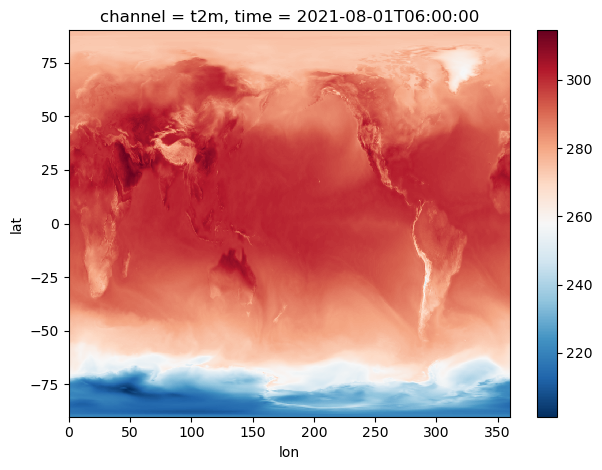

In [38]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=1).squeeze().plot.pcolormesh(ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.show()

## Compare: CDS Dataset

In [39]:
data_source = cds.DataSource(time_loop.in_channel_names)

In [40]:
%%time
ds_cds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source, 
    time=t0
)

CPU times: user 4.55 s, sys: 33.3 s, total: 37.8 s
Wall time: 50.4 s


Below, we calculate the difference between the two fields: 
1. field 1 generated by data we downloaded manually and saved
2. field 2 generated by data we downloaded via the CDSAPI

In [41]:

# calculate the difference
diff_t2m = np.abs(ds.sel(channel="t2m") - ds_cds.sel(channel="t2m")).mean()

In [42]:
diff_t2m.values

array(0., dtype=float32)

In [43]:
from pathlib import Path

save_dir = Path("/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip")
save_name = f"{model_name.replace('_','')}"
save_name += f"-{str(t0.date()).replace('-','')}"
save_name += ".nc"
save_name = save_name.replace('-','_')
save_dir = save_dir.joinpath(save_name)
save_dir

PosixPath('/pool/proyectos/CLINT/temp/sa4attrs/data/pred/earth2mip/fcnv2sm_20210801.nc')

In [23]:
# ds.to_netcdf()